## Candida albicans

This analysis solely focuses on the presence of Candida. It is based on the Aspergillus notebook.

## Import the libraries

In [1]:
import os
import sys
from socket import gethostname

hostname = gethostname()

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib

sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "species"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel='subsystems_norm_ss.tsv.gz', all_taxa=True, taxa=taxa)

merged = df.join(metadata, how='inner')

print(f"The merged Data Frame has shape: {merged.shape}")

Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems


The merged Data Frame has shape: (127, 32306)


# Who has Candida (should be about 40 samples)

In [2]:
for c in merged.columns:
    if 'candida' in c.lower() and 'candidate' not in c.lower():
        print(c)

Nonomuraea candida
Chryseobacterium candidae
Folsomia candida
uncultured Candida
Candida albicans
Candida blackwelliae
Candida bohioensis
Candida corydali
Candida dubliniensis
Candida gigantensis
Candida maltosa
Candida metapsilosis
Candida orthopsilosis
Candida oxycetoniae
Candida parapsilosis
Candida prachuapensis
Candida pseudojiufengensis
Candida tropicalis
Candida verbasci
Candida viswanathii
[Candida] oleophila
[Candida] railenensis
[Candida] subhashii
[Candida] auris
[Candida] duobushaemulonis
[Candida] haemuloni
[Candida] intermedia
[Candida] pseudohaemulonii
[Candida] norvegica
[Candida] arabinofermentans
[Candida] boidinii
[Candida] inconspicua
Albugo candida
CS_Candida albicans
N12M_Candida albicans


### A simple plot of _C. albicans_ vs. culturing

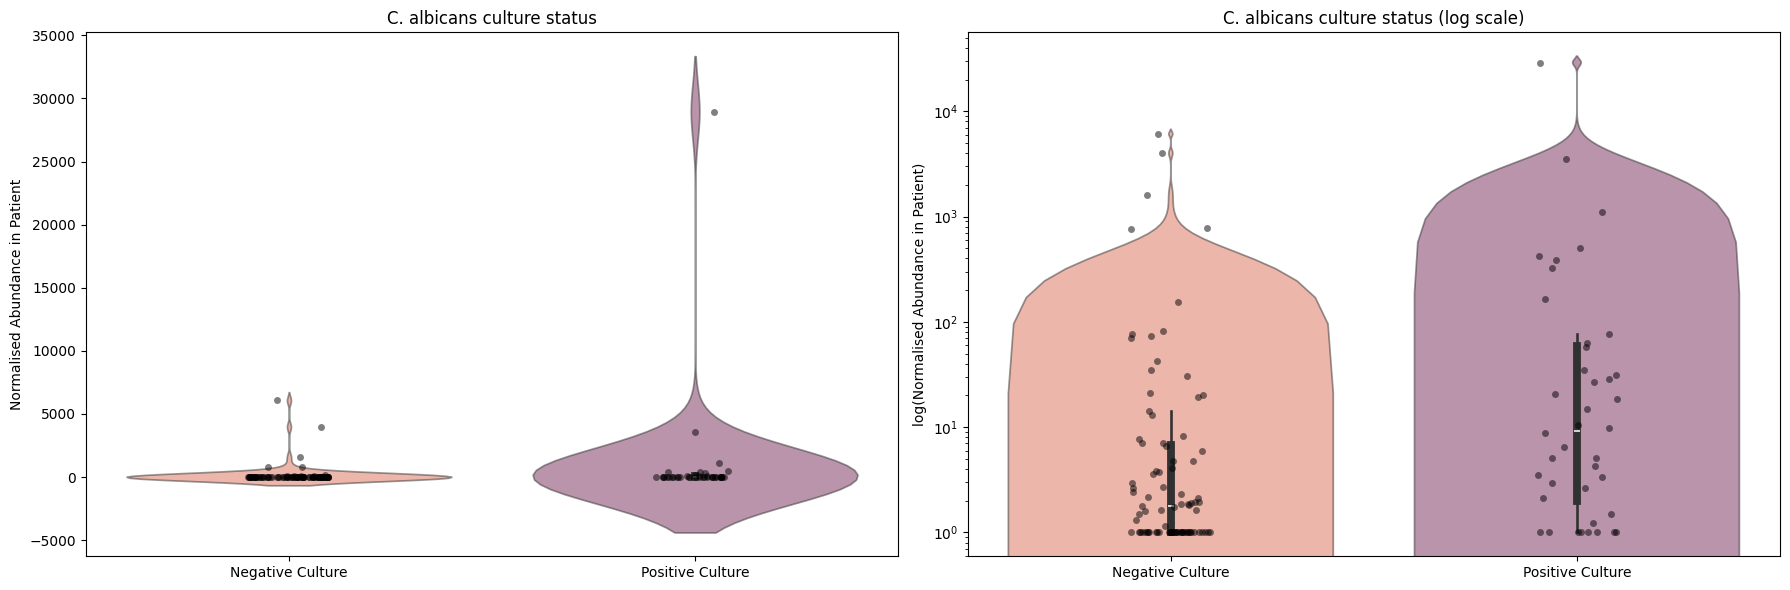

In [3]:
fig, ax = plt.subplots(figsize=(18, 6), nrows=1, ncols=2, sharex=False, sharey=False)

subset_data = merged[merged['CS_Candida albicans'].notna()]
#subset_data['Candida albicans'] = subset_data['Candida albicans'] + sys.float_info.epsilon
subset_data['Candida albicans'] = subset_data['Candida albicans'] + 1

f = sns.violinplot(x='CS_Candida albicans', y='Candida albicans', data=subset_data, hue='CS_Candida albicans', palette='rocket_r', ax=ax[0], alpha=0.5, legend=False)
f = sns.stripplot(x='CS_Candida albicans', y='Candida albicans', data=subset_data, color='black', jitter=True, alpha=0.5, ax=ax[0], legend=False)
f.set_xlabel("")
f.set_ylabel("Normalised Abundance in Patient")
f.set_xlim(-0.5, 1.5)
f.set_xticks(ticks=[0, 1], labels=["Negative Culture", "Positive Culture"])
f.set_title(f"C. albicans culture status")

g = sns.violinplot(x='CS_Candida albicans', y='Candida albicans', data=subset_data, hue='CS_Candida albicans', palette='rocket_r', ax=ax[1], alpha=0.5, legend=False)
g = sns.stripplot(x='CS_Candida albicans', y='Candida albicans', data=subset_data, color='black', jitter=True, alpha=0.5, ax=ax[1], legend=False)
g.set_xlabel("")
g.set_ylabel("log(Normalised Abundance in Patient)")
g.set_xlim(-0.5, 1.5)
g.set_xticks(ticks=[0, 1], labels=["Negative Culture", "Positive Culture"])
g.set_title(f"C. albicans culture status (log scale)")
g.set(yscale="log")

plt.tight_layout()
plt.show()

# ROC Curve

Just based on sequences

Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems
Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems
Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems
Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems
Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems
Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems


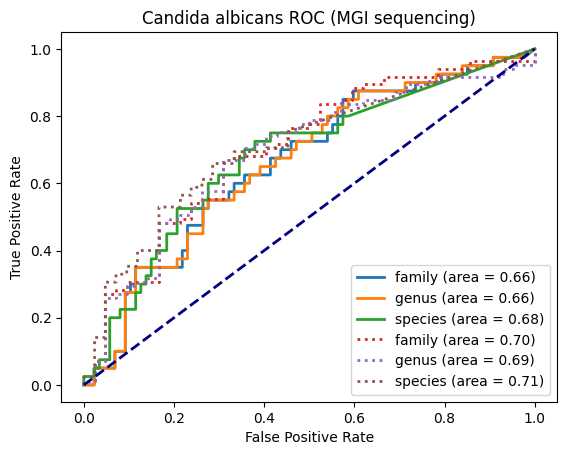

In [4]:
sequence_type = "MGI"
sslevel = 'subsystems_norm_ss.tsv.gz'
aspname = {'family': 'Debaryomycetaceae', 'genus': 'Candida', 'species': 'Candida albicans'}

plt.figure()

roc_data = pd.DataFrame()
for taxa in aspname:
    df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel=sslevel, taxa=taxa, all_taxa=True, verbose=False)
    
    merged = df[[aspname[taxa]]].join(metadata[['pwCF_ID', 'Sample date', 'Sum of antifungals', 'CS_Candida albicans', 'N12M_Candida albicans']], how='inner')
    res = merged.sort_values(by=['pwCF_ID', 'Sample date'])
    
    y_true = res['CS_Candida albicans']
    y_scores = res[aspname[taxa]]

    roc_data[f'{taxa} true'] = y_true
    roc_data[f'{taxa} score'] = y_scores
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{taxa} (area = {roc_auc:.2f})')

for taxa in aspname:
    df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel=sslevel, taxa=taxa, all_taxa=True, verbose=False)
    
    merged = df[[aspname[taxa]]].join(metadata[['pwCF_ID', 'Sample date', 'Sum of antifungals', 'CS_Candida albicans', 'N12M_Candida albicans']], how='inner')
    res = merged.sort_values(by=['pwCF_ID', 'Sample date'])
    
    y_true = res[['CS_Candida albicans', 'N12M_Candida albicans']].astype(bool).any(axis=1)
    y_scores = res[aspname[taxa]]

    roc_data[f'{taxa} true'] = y_true
    roc_data[f'{taxa} score'] = y_scores
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, linestyle=':', label=f'{taxa} (area = {roc_auc:.2f})')


    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Candida albicans ROC ({sequence_type} sequencing)')
plt.legend(loc="lower right")
plt.show()

# Autoencoded Clusters

In [5]:
encoder_models = 'cluster_gbrfs_eukaryotes'
if not os.path.exists(os.path.join(encoder_models, 'clusters.json')):
    print("Please run the autoencoder code before trying to load the models.", file=sys.stderr)
    exit(1)

if not os.path.exists(os.path.join(encoder_models, 'pc_df.tsv')):
    print("Please create and save the PCA before trying to load the models.", file=sys.stderr)
    exit(1)

with open(os.path.join(encoder_models, 'clusters.json'), 'r') as file:
    data = json.load(file)
tmpjsondf = pd.DataFrame(list(data.items()), columns=['Cluster', 'Feature'])
cluster_assignments = tmpjsondf.explode('Feature').reset_index(drop=True)
cluster_assignments['Cluster'] = cluster_assignments['Cluster'].astype(int)

pc_df = pd.read_csv(os.path.join(encoder_models, 'pc_df.tsv'), sep="\t", index_col=0)

Run the GBRF

The data for the classifier is {'no': 87, 'yes': 40} variables
We used 637 estimators for the random forest classifier
Mean squared error for CS_Candida albicans using classifier is 0.4230769230769231


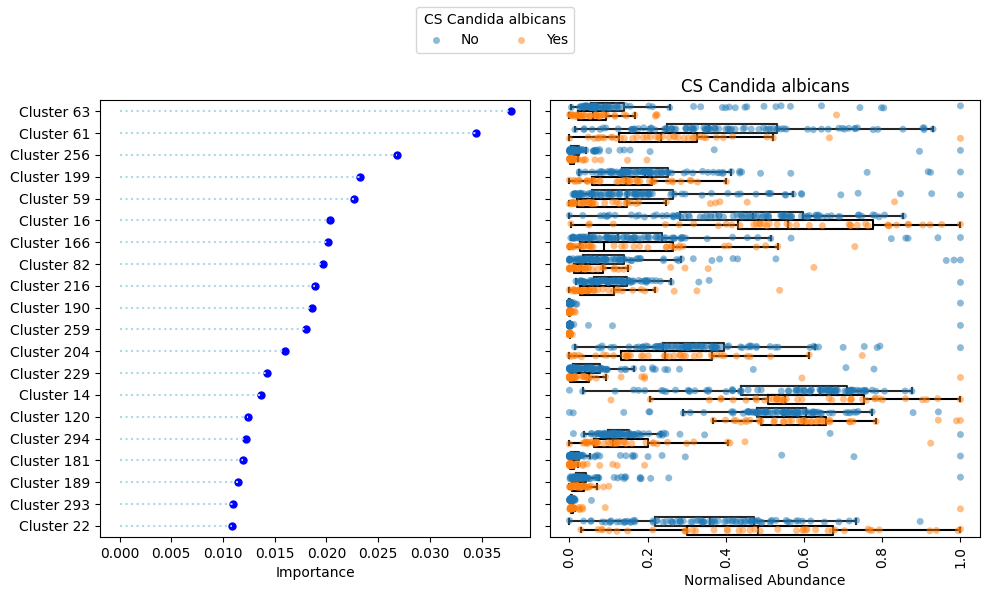

In [6]:
intcol = 'CS_Candida albicans'

intcol_title = replace_index.sub('', intcol).replace('_', ' ')
merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

if categorical_data:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_classifier_model(X, y, n_estimators=1000, n_iter_no_change=20)
  met = 'classifier'
else:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_regressor_model(X, y)
  met = 'regressor'

print(f"We used {model.n_estimators_} estimators for the random forest {met}", file=sys.stderr)
print(f"Mean squared error for {intcol} using {met} is {mse}", file=sys.stderr)
cf_analysis_lib.plot_one_top_feature(merged_df, feature_importances_sorted, intcol, intcol_title, 
                                     custom_labels, 
                                     plot_legend=True)

In [12]:
cluster_assignments[cluster_assignments['Cluster']== 16]

,Cluster,Feature
50,16,Threonine synthase cluster
51,16,Purine nucleotide synthesis regulator
52,16,Pyruvate formate-lyase cluster with possible r...
53,16,Cell envelope-associated LytR-CpsA-Psr transcr...
54,16,Fermentations: Mixed acid
55,16,Mevalonate metabolic pathway
56,16,Ribosome activity modulation


In [15]:
cluster_assignments[cluster_assignments['Feature'].str.lower().str.contains('debaryomycetaceae')]

,Cluster,Feature
1693,238,Debaryomycetaceae


### Autoencoder ROC curve

Cluster 63 (area = 0.65)
Cluster 61 (area = 0.71)
Cluster 256 (area = 0.63)
Cluster 199 (area = 0.66)
Cluster 59 (area = 0.68)


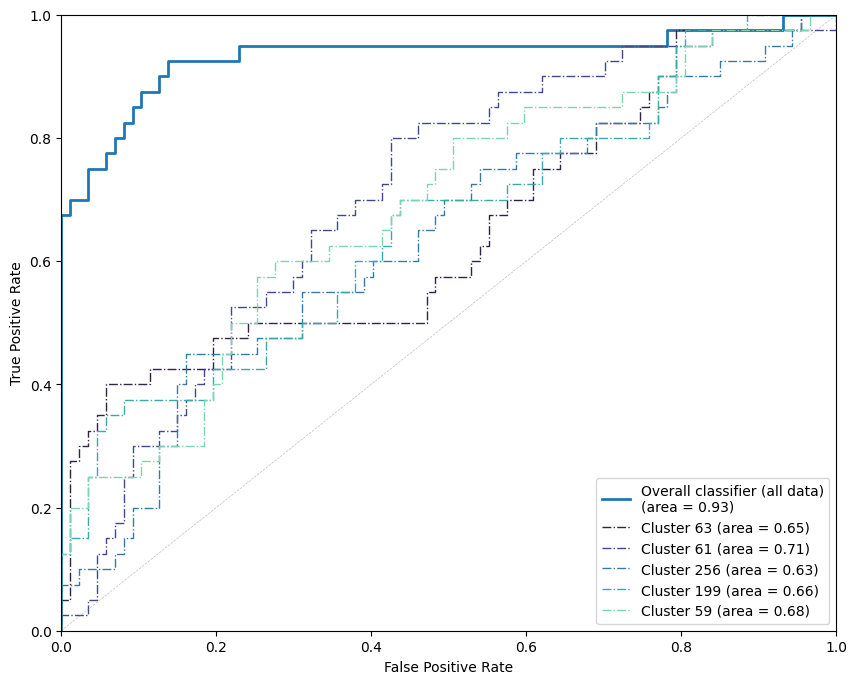

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
# ax = cf_analysis_lib.plot_roc_curves(model, X, y, feature_importances_sorted, met, intcol_title, ax=ax)
ax = cf_analysis_lib.plot_roc_curves(model, X, y, feature_importances_sorted, met, "", ax=ax, verbose=True)
plt.show()